## Поиск геометрических фигур с помощью Canny (Computer Vision)

Импорт библиотек и настройка

In [2]:
import cv2
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

# Настройка размера графиков
matplotlib.rcParams['figure.figsize'] = (20, 10)
print("✅ Библиотеки успешно импортированы")

✅ Библиотеки успешно импортированы


In [3]:
# Вставьте эту команду в свою ячейку кода и выполните:
!pip install opencv-python

# ИЛИ если нужны дополнительные модули:
!pip install opencv-contrib-python

Загрузка и проверка изображения

✅ Изображение загружено успешно
📐 Исходный размер: (1536, 1024, 3)
📏 Новый размер: (640, 480, 3)


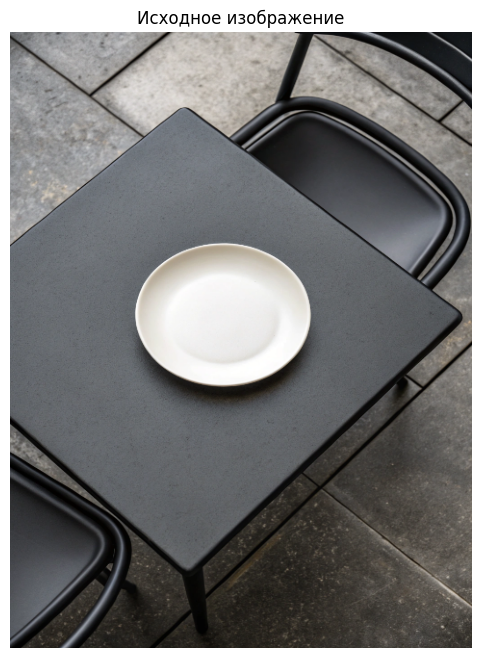

In [5]:
# Загрузка изображения
image_path = '/content/sample_data/cv2.imread.png'
image = cv2.imread(image_path)

# Проверка успешности загрузки
if image is None:
    print(f"❌ Ошибка: Не удалось загрузить изображение по пути: {image_path}")
    print("Проверьте:")
    print("- Существует ли файл")
    print("- Правильно ли указан путь")
    exit()
else:
    print(f"✅ Изображение загружено успешно")
    print(f"📐 Исходный размер: {image.shape}")

# Изменение размера
image = cv2.resize(image, (480, 640))
print(f"📏 Новый размер: {image.shape}")

# Отображение исходного изображения
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Исходное изображение")
plt.axis('off')
plt.show()


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Предварительная обработка изображения

✅ Конвертация в grayscale выполнена
✅ Размытие применено
✅ Границы выделены (Canny)


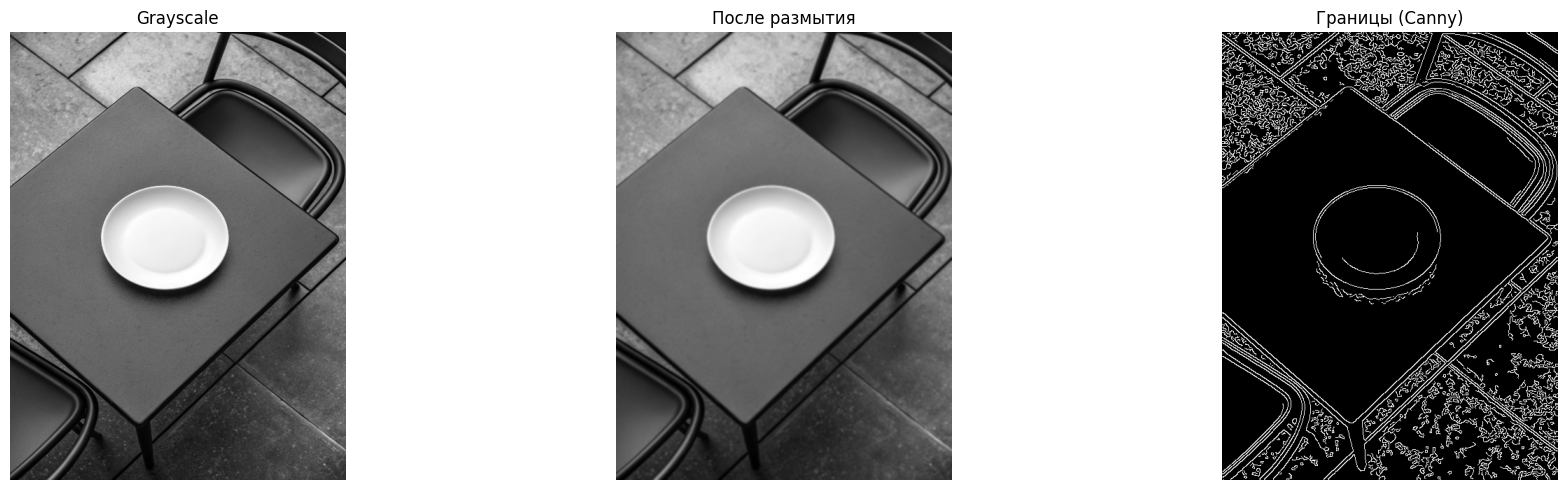

In [7]:
# Конвертация в grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("✅ Конвертация в grayscale выполнена")

# Применение размытия для уменьшения шума
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)
print("✅ Размытие применено")

# Выделение границ с помощью детектора Canny
edged = cv2.Canny(gray_blurred, 10, 50)
print("✅ Границы выделены (Canny)")

# Визуализация этапов предобработки
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Grayscale")
axes[0].axis('off')

axes[1].imshow(gray_blurred, cmap='gray')
axes[1].set_title("После размытия")
axes[1].axis('off')

axes[2].imshow(edged, cmap='gray')
axes[2].set_title("Границы (Canny)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Поиск контуров

In [8]:
# Поиск контуров
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]  # Совместимость с разными версиями OpenCV

if len(cnts) == 0:
    print("❌ Контуры не найдены!")
    exit()
else:
    print(f"✅ Найдено контуров: {len(cnts)}")

# Сортировка контуров по площади (от большего к меньшему)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
print("✅ Контуры отсортированы по площади")

✅ Найдено контуров: 892
✅ Контуры отсортированы по площади


Поиск и отрисовка четырехугольника


🔍 Поиск четырехугольника...
✅ Четырехугольник найден!


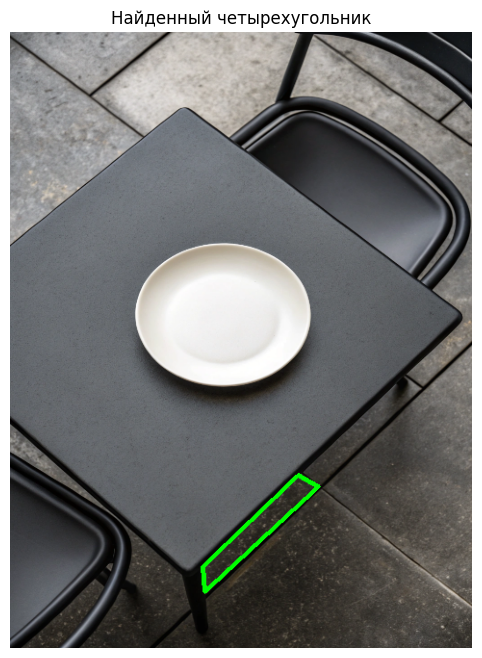

In [9]:
print("\n🔍 Поиск четырехугольника...")
solution_rect = None

for c in cnts:
    # Вычисление периметра для аппроксимации
    peri = cv2.arcLength(c, True)
    # Аппроксимация контура
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # Если контур имеет 4 вершины - это наш четырехугольник
    if len(approx) == 4:
        solution_rect = approx
        print("✅ Четырехугольник найден!")
        break

# Отрисовка результата
if solution_rect is not None:
    image_rect = image.copy()
    cv2.drawContours(image_rect, [solution_rect], -1, (0, 255, 0), 3)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image_rect, cv2.COLOR_BGR2RGB))
    plt.title("Найденный четырехугольник")
    plt.axis('off')
    plt.show()
else:
    print("❌ Четырехугольник не найден")

Поиск и отрисовка круглых объектов


🔍 Поиск круглых объектов...
✅ Круглый объект найден (отношение площадей: 0.81)


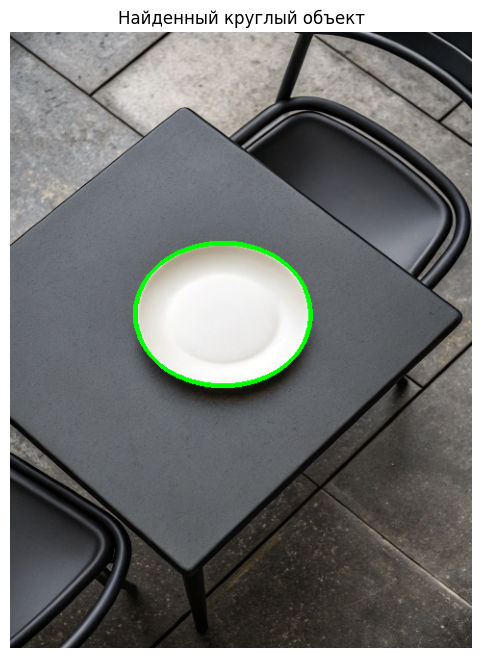

In [10]:
print("\n🔍 Поиск круглых объектов...")
solution_circle = None

for c in cnts:
    # Получение минимальной окружающей окружности
    (x, y), radius = cv2.minEnclosingCircle(c)
    circle_area = np.pi * (radius ** 2)
    contour_area = cv2.contourArea(c)

    # Проверка на схожесть с кругом (площадь контура близка к площади окружности)
    if contour_area > 0 and circle_area > 0:  # Защита от деления на ноль
        ratio = contour_area / circle_area
        if ratio > 0.8:  # Если отношение больше 80% - считаем кругом
            solution_circle = c
            print(f"✅ Круглый объект найден (отношение площадей: {ratio:.2f})")
            break

# Отрисовка результата
if solution_circle is not None:
    image_circle = image.copy()
    cv2.drawContours(image_circle, [solution_circle], -1, (0, 255, 0), 3)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image_circle, cv2.COLOR_BGR2RGB))
    plt.title("Найденный круглый объект")
    plt.axis('off')
    plt.show()
else:
    print("❌ Круглые объекты не найдены")

Итоговый отчет

In [11]:
print("\n" + "="*50)
print("📊 ИТОГОВЫЙ ОТЧЕТ")
print("="*50)
print(f"📁 Изображение: {image_path}")
print(f"📐 Размер: {image.shape}")
print(f"🔍 Найдено контуров: {len(cnts)}")
print(f"⬜ Найден четырехугольник: {'✅ Да' if solution_rect is not None else '❌ Нет'}")
print(f"⭕ Найден круглый объект: {'✅ Да' if solution_circle is not None else '❌ Нет'}")
print("="*50)


📊 ИТОГОВЫЙ ОТЧЕТ
📁 Изображение: /content/sample_data/cv2.imread.png
📐 Размер: (640, 480, 3)
🔍 Найдено контуров: 892
⬜ Найден четырехугольник: ✅ Да
⭕ Найден круглый объект: ✅ Да
